# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2019

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import utils
import os

In [2]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

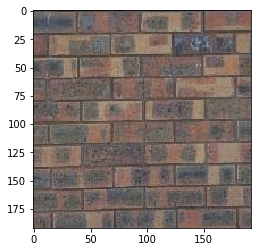

In [120]:
sample_img_dir = 'samples/bricks_small.jpg' # feel free to change
sample_img = None
if os.path.exists(sample_img_dir):
    sample_img = cv2.imread(sample_img_dir)
    sample_out = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
    plt.imshow(sample_out)

In [9]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    out = np.zeros((out_size,out_size,3), np.uint8)
    sample_size = len(sample)
    tile_size = int(out_size/patch_size)
    random_ints = np.random.randint(sample_size-patch_size, size=(tile_size*tile_size,tile_size*tile_size))
    c = 0
    for i in range(tile_size):
        for j in range(tile_size):
            x,y = i*patch_size,j*patch_size
            xr,yr = random_ints[0,c],random_ints[1,c]
            out[x:x+patch_size,y:y+patch_size] = sample[xr:xr+patch_size,yr:yr+patch_size]
            c += 1

    return out

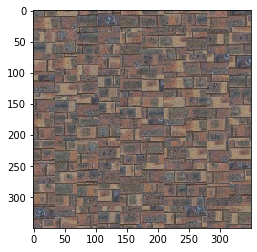

In [10]:
out_size = 350  # feel free to change to debug
patch_size = 35 # feel free to change to debug
res = quilt_random(sample_img, out_size, patch_size)
if res.any():
    res_out = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(res_out)

### Part II: Overlapping Patches (30 pts)

In [200]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: int
    :return: numpy.ndarray
    """
    def ssd_patch(sample,template,mask):
        b,g,r = cv2.split(sample/255.0)
        t_b, t_g, t_r = cv2.split(template)
        half = int(patch_size/2)
        ssd_b = np.zeros((len(sample),len(sample)), np.float32)
        for i in range(len(sample)-patch_size):
            for j in range(len(sample)-patch_size):
                ssd_b[i+half,j+half] = (((b[i:i+patch_size,j:j+patch_size]*mask)-t_b) ** 2).sum()
        ssd_g = np.zeros((len(sample),len(sample)), np.float32)
        for i in range(len(sample)-patch_size):
            for j in range(len(sample)-patch_size):
                ssd_g[i+half,j+half] = (((g[i:i+patch_size,j:j+patch_size]*mask)-t_g) ** 2).sum()
        ssd_r = np.zeros((len(sample),len(sample)), np.float32)
        for i in range(len(sample)-patch_size):
            for j in range(len(sample)-patch_size):
                ssd_r[i+half,j+half] = (((r[i:i+patch_size,j:j+patch_size]*mask)-t_r) ** 2).sum()
#         ssd_b = ((mask*t_b)**2).sum() - 2 * cv2.filter2D(b, ddepth=-1, kernel = t_b) + cv2.filter2D(b ** 2, ddepth=-1, kernel=mask)
#         ssd_g = ((mask*t_g)**2).sum() - 2 * cv2.filter2D(g, ddepth=-1, kernel = t_g) + cv2.filter2D(g ** 2, ddepth=-1, kernel=mask)
#         ssd_r = ((mask*t_r)**2).sum() - 2 * cv2.filter2D(r, ddepth=-1, kernel = t_r) + cv2.filter2D(r ** 2, ddepth=-1, kernel=mask)
        ssd = ssd_b + ssd_g + ssd_r
        return ssd
    
    def choose_sample(ssd,minc,tol,patch_size):
        rows,cols = [], []
        half = int(patch_size/2)
        for i in range(len(ssd)):
            for j in range(len(ssd)):
                if ssd[i,j] == 0:
                    continue
                if ssd[i,j] < minc*(1+tol):
                    rows.append(i)
                    cols.append(j)
        r = int(np.random.randint(len(rows),size=1))
        row, col = rows[r], cols[r]
        return row, col
        
    out = np.zeros((out_size,out_size,3), np.float32)
    step = patch_size-overlap
    half = int(patch_size/2)
    small_cost_value = 1
    
    random_ints = np.random.randint(len(sample)-patch_size, size=2)
    xr,yr = random_ints[0],random_ints[1]
#     xr,yr = 0, 0
    out[0:patch_size,0:patch_size] = sample[xr:xr+patch_size,yr:yr+patch_size]/255.0
    i = 0
    j = step
    while i < out_size-patch_size:
        while j < out_size-patch_size:
            mask = np.zeros((patch_size,patch_size),np.float32)
            if i >= step:
                mask[0:overlap,:] = 1.0
            if j >= step:
                mask[:,0:overlap] = 1.0
            template = out[i:i+patch_size,j:j+patch_size]
            ssd = ssd_patch(sample,template,mask)
            minc = np.min(ssd[np.nonzero(ssd)])
            minc = max(minc,small_cost_value)
            row,col = choose_sample(ssd,minc,tol,patch_size)
            out[i:i+patch_size,j:j+patch_size] = sample[row-half:row+half+1,col-half:col+half+1]/255.0
            j += step
        j = 0
        i += step
    # Todo 
    return out

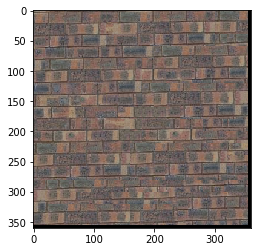

In [13]:
res = quilt_simple(sample_img, 360, 35, 15, 0.00001) #feel free to change parameters to get best results
if res.any():
    res_out = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(res_out)

### Part III: Seam Finding (20 pts)


In [8]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [192]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: int
    :return: numpy.ndarray
    """
    def ssd_patch(sample,template,mask):
        b,g,r = cv2.split(sample/255.0)
        t_b, t_g, t_r = cv2.split(template)
        half = int(patch_size/2)
        ssd_b = np.zeros((len(sample),len(sample)), np.float32)
        for i in range(len(sample)-patch_size):
            for j in range(len(sample)-patch_size):
                ssd_b[i+half,j+half] = (((b[i:i+patch_size,j:j+patch_size]*mask)-t_b) ** 2).sum()
        ssd_g = np.zeros((len(sample),len(sample)), np.float32)
        for i in range(len(sample)-patch_size):
            for j in range(len(sample)-patch_size):
                ssd_g[i+half,j+half] = (((g[i:i+patch_size,j:j+patch_size]*mask)-t_g) ** 2).sum()
        ssd_r = np.zeros((len(sample),len(sample)), np.float32)
        for i in range(len(sample)-patch_size):
            for j in range(len(sample)-patch_size):
                ssd_r[i+half,j+half] = (((r[i:i+patch_size,j:j+patch_size]*mask)-t_r) ** 2).sum()
#         ssd_b = ((mask*t_b)**2).sum() - 2 * cv2.filter2D(b, ddepth=-1, kernel = t_b) + cv2.filter2D(b ** 2, ddepth=-1, kernel=mask)
#         ssd_g = ((mask*t_g)**2).sum() - 2 * cv2.filter2D(g, ddepth=-1, kernel = t_g) + cv2.filter2D(g ** 2, ddepth=-1, kernel=mask)
#         ssd_r = ((mask*t_r)**2).sum() - 2 * cv2.filter2D(r, ddepth=-1, kernel = t_r) + cv2.filter2D(r ** 2, ddepth=-1, kernel=mask)
        ssd = ssd_b + ssd_g + ssd_r
        return ssd
    
    def choose_sample(ssd,minc,tol,patch_size):
        rows,cols = [], []
        half = int(patch_size/2)
        for i in range(len(ssd)):
            for j in range(len(ssd)):
                if ssd[i,j] == 0:
                    continue
                if ssd[i,j] < minc*(1+tol):
                    rows.append(i)
                    cols.append(j)
        r = int(np.random.randint(len(rows),size=1))
        row, col = rows[r], cols[r]
        return row, col
        
    out = np.zeros((out_size,out_size,3), np.float32)
    step = patch_size-overlap
    half = int(patch_size/2)
    small_cost_value = 0.0001
    
    random_ints = np.random.randint(len(sample)-patch_size, size=2)
    xr,yr = random_ints[0],random_ints[1]
    out[0:patch_size,0:patch_size] = sample[xr:xr+patch_size,yr:yr+patch_size]/256.0
    
#     patch1 = sample[xr:xr+patch_size,yr:yr+patch_size]
#     patch1 = cv2.cvtColor(patch1, cv2.COLOR_BGR2RGB)
#     plt.figure()
#     plt.imshow(patch1)
    
    i = 0
    j = step
    while i < out_size-patch_size:
        while j < out_size-patch_size:
            mask = np.zeros((patch_size,patch_size),np.float32)
            h = False
            v = False
            if i >= step:
                h = True
                mask[0:overlap,:] = 1.0
            if j >= step:
                v = True
                mask[:,0:overlap] = 1.0
            template = out[i:i+patch_size,j:j+patch_size]
            ssd = ssd_patch(sample,template,mask)
            minc = np.min(ssd[np.nonzero(ssd)])
            minc = max(minc,small_cost_value)
            row,col = choose_sample(ssd,minc,tol,patch_size)
            patch = sample[row-half:row+half+1,col-half:col+half+1]/256.0
            
#             patch2 = sample[row-half:row+half+1,col-half:col+half+1]
#             patch2 = cv2.cvtColor(patch2, cv2.COLOR_BGR2RGB)
#             plt.figure()
#             plt.imshow(patch2)
            
            tb, tg, tr = cv2.split(template)
            pb, pg, pr = cv2.split(patch)
            cost = ((tb-pb) ** 2) + ((tg-pg) ** 2) + ((tr-pr) ** 2)
            patch_mask = np.zeros((patch_size,patch_size,3), np.uint8)
            if h and v:
                mask1 = np.zeros((patch_size,patch_size,3), np.uint8)
                mask1[:,:,0] = cut(cost.T).T
                mask1[:,:,1] = mask1[:,:,0]
                mask1[:,:,2] = mask1[:,:,0]
                mask2 = np.zeros((patch_size,patch_size,3), np.uint8)
                mask2[:,:,0] = cut(cost)
                mask2[:,:,1] = mask2[:,:,0]
                mask2[:,:,2] = mask2[:,:,0]
                patch_mask = np.bitwise_and(mask1,mask2)
            elif h:
                patch_mask[:,:,0] = cut(cost)
                patch_mask[:,:,1] = patch_mask[:,:,0]
                patch_mask[:,:,2] = patch_mask[:,:,0]
            elif v:
                patch_mask[:,:,0] = cut(cost.T).T
                patch_mask[:,:,1] = patch_mask[:,:,0]
                patch_mask[:,:,2] = patch_mask[:,:,0]
            inv_patch_mask = np.where(patch_mask == 0, 1, 0)
            
#             plt.figure()
#             plt.imshow(patch_mask*256.0)
            
            out[i:i+patch_size,j:j+patch_size] = patch_mask*patch + template*inv_patch_mask
            
#             plot_overlap = np.zeros((patch_size,2*patch_size-overlap,3), np.float32)
#             plot_overlap[:,:,:] = out[i:i+patch_size,j-step:j+patch_size]
            
#             plot_mask = np.zeros((patch_size,patch_size,3), np.uint8)
#             for ii in range(patch_size):
#                 for jj in range(1,patch_size):
#                     if patch_mask[ii,jj,0] == patch_mask[ii,jj-1,0]:
#                         pass
#                     else:
#                         plot_mask[ii,jj,0] = 0
#                         plot_mask[ii,jj,1] = 0
#                         plot_mask[ii,jj,2] = 1
                        
#             plt.figure()
#             plot_overlap_out = cv2.cvtColor(plot_overlap, cv2.COLOR_BGR2RGB)
#             plt.imshow(plot_overlap_out)
            
#             plot_overlap[0:patch_size,0:patch_size,:] += plot_mask
#             plot_overlap = cv2.cvtColor(plot_overlap, cv2.COLOR_BGR2RGB)
#             plt.figure()
#             plt.imshow(plot_overlap)
            
#             plt.figure()
#             plt.imshow(cost[0:patch_size,0:overlap])
            
#             for ii in range(patch_size):
#                 for jj in range(overlap):
#                     if plot_mask[ii,jj,2]:
#                         cost[ii,jj] = 1.0
#             plt.figure()
#             plt.imshow(cost[0:patch_size,0:overlap])
            
            j += step
        j = 0
        i += step
    # Todo 
    return out

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


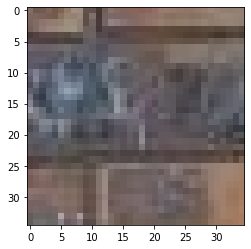

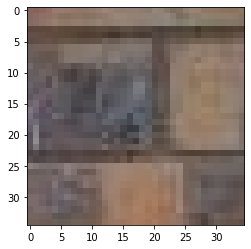

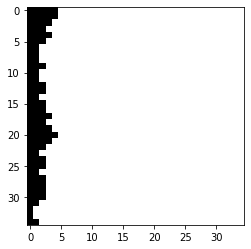

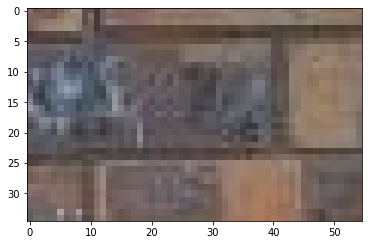

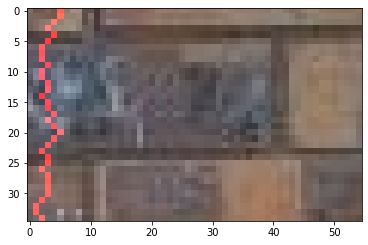

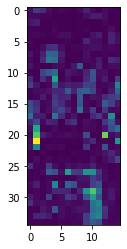

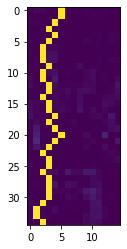

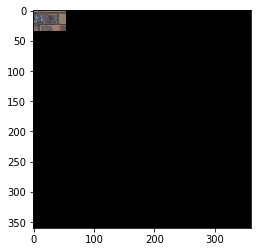

In [171]:
res = quilt_cut(sample_img, 360, 35, 15, 0.0001)
if res.any():
    res_out = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(res_out)

### OTHER TEXTURES

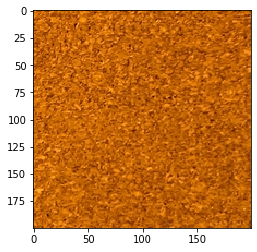

In [202]:
sample_img_dir = 'samples/cork.jpg' # feel free to change
sample_img = None
if os.path.exists(sample_img_dir):
    sample_img = cv2.imread(sample_img_dir)
    sample_out = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(sample_out)

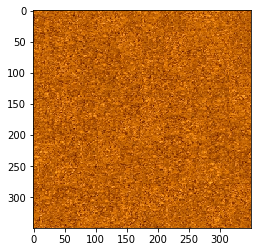

In [203]:
out_size = 350  # feel free to change to debug
patch_size = 35 # feel free to change to debug
res = quilt_random(sample_img, out_size, patch_size)
if res.any():
    res_out = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(res_out)

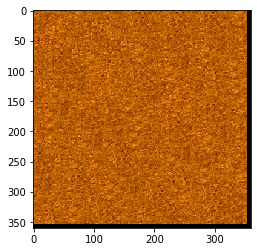

In [206]:
res = quilt_simple(sample_img, 360, 35, 6, 0.001) #feel free to change parameters to get best results
if res.any():
    res_out = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(res_out)

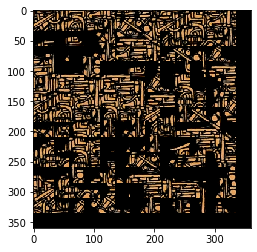

In [195]:
res = quilt_cut(sample_img, 360, 35, 10, 0.0001)
if res.any():
    res_out = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(res_out)

### part IV: Texture Transfer (30 pts)

In [207]:
def texture_transfer(sample, target, patch_size, overlap, tol, alpha):
    """
    Feel free to add function parameters
    """
    def ssd_patch(sample,template,mask):
        b,g,r = cv2.split(sample/255.0)
        t_b, t_g, t_r = cv2.split(template)
        half = int(patch_size/2)
        w = len(sample[0,:,:])
        h = len(sample[:,0,:])
        ssd_b = np.zeros((h,w), np.float32)
        for i in range(h-patch_size):
            for j in range(w-patch_size):
                ssd_b[i+half,j+half] = (((b[i:i+patch_size,j:j+patch_size]*mask)-t_b) ** 2).sum()
        ssd_g = np.zeros((h,w), np.float32)
        for i in range(h-patch_size):
            for j in range(w-patch_size):
                ssd_g[i+half,j+half] = (((g[i:i+patch_size,j:j+patch_size]*mask)-t_g) ** 2).sum()
        ssd_r = np.zeros((h,w), np.float32)
        for i in range(h-patch_size):
            for j in range(w-patch_size):
                ssd_r[i+half,j+half] = (((r[i:i+patch_size,j:j+patch_size]*mask)-t_r) ** 2).sum()
#         ssd_b = ((mask*t_b)**2).sum() - 2 * cv2.filter2D(b, ddepth=-1, kernel = t_b) + cv2.filter2D(b ** 2, ddepth=-1, kernel=mask)
#         ssd_g = ((mask*t_g)**2).sum() - 2 * cv2.filter2D(g, ddepth=-1, kernel = t_g) + cv2.filter2D(g ** 2, ddepth=-1, kernel=mask)
#         ssd_r = ((mask*t_r)**2).sum() - 2 * cv2.filter2D(r, ddepth=-1, kernel = t_r) + cv2.filter2D(r ** 2, ddepth=-1, kernel=mask)
        ssd = ssd_b + ssd_g + ssd_r
        return ssd
    
    def choose_sample(ssd,minc,tol,patch_size):
        rows,cols = [], []
        half = int(patch_size/2)
        for i in range(len(ssd[:,0])):
            for j in range(len(ssd[0,:])):
                if ssd[i,j] == 0:
                    continue
                if ssd[i,j] < minc*(1+tol):
                    rows.append(i)
                    cols.append(j)
        r = int(np.random.randint(len(rows),size=1))
        row, col = rows[r], cols[r]
        return row, col
    
    width = len(target[0,:,:])
    height = len(target[:,0,:])
    out = np.zeros((height,width,3), np.float32)
    step = patch_size-overlap
    half = int(patch_size/2)
    small_cost_value = 1
    
    xr = int(np.random.randint(len(sample[:,0,:])-patch_size, size=1))
    yr = int(np.random.randint(len(sample[0,:,:])-patch_size, size=1))
    out[0:patch_size,0:patch_size] = sample[xr:xr+patch_size,yr:yr+patch_size]/255.0
    i = 0
    j = step
    while i < height-patch_size:
        while j < width-patch_size:
            mask = np.zeros((patch_size,patch_size),np.float32)
            h = False
            v = False
            if i >= step:
                h = True
                mask[0:overlap,:] = 1.0
            if j >= step:
                v = True
                mask[:,0:overlap] = 1.0
            template = out[i:i+patch_size,j:j+patch_size]
            transfer = target[i:i+patch_size,j:j+patch_size]/255.0
            ssd_p = ssd_patch(sample,template,mask)
            ssd_t = ssd_patch(sample,transfer,mask)
            ssd = alpha*ssd_p+(1-alpha)*ssd_t
            minc = np.min(ssd[np.nonzero(ssd)])
            minc = max(minc,small_cost_value)
            row,col = choose_sample(ssd,minc,tol,patch_size)
            patch = sample[row-half:row+half+1,col-half:col+half+1]/255.0
            tb, tg, tr = cv2.split(template)
            pb, pg, pr = cv2.split(patch)
            cost = ((tb-pb) ** 2) + ((tg-pg) ** 2) + ((tr-pr) ** 2)
            patch_mask = np.zeros((patch_size,patch_size,3), np.uint8)
            if h and v:
                mask1 = np.zeros((patch_size,patch_size,3), np.uint8)
                mask1[:,:,0] = cut(cost.T).T
                mask1[:,:,1] = mask1[:,:,0]
                mask1[:,:,2] = mask1[:,:,0]
                mask2 = np.zeros((patch_size,patch_size,3), np.uint8)
                mask2[:,:,0] = cut(cost)
                mask2[:,:,1] = mask2[:,:,0]
                mask2[:,:,2] = mask2[:,:,0]
                patch_mask = np.bitwise_and(mask1,mask2)
            elif h:
                patch_mask[:,:,0] = cut(cost)
                patch_mask[:,:,1] = patch_mask[:,:,0]
                patch_mask[:,:,2] = patch_mask[:,:,0]
            elif v:
                patch_mask[:,:,0] = cut(cost.T).T
                patch_mask[:,:,1] = patch_mask[:,:,0]
                patch_mask[:,:,2] = patch_mask[:,:,0]
            inv_patch_mask = np.where(patch_mask == 0, 1, 0)
            out[i:i+patch_size,j:j+patch_size] = patch_mask*patch + template*inv_patch_mask
            j += step
        j = 0
        i += step
    # Todo 
    return out

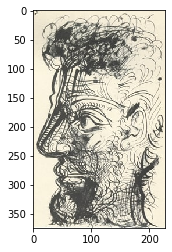

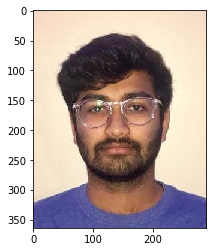

In [222]:
sample_img_dir = 'samples/sketch.jpg' # feel free to change
sample_img = None
if os.path.exists(sample_img_dir):
    sample_img = cv2.imread(sample_img_dir)
    sample_out = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(sample_out)

target_img_dir = 'samples/nikhil.jpg' # feel free to change
target_img = None
if os.path.exists(target_img_dir):
    target_img = cv2.imread(target_img_dir)
    target_out = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(target_out)

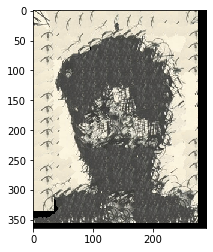

In [223]:
res = texture_transfer(sample_img, target_img, 35, 15, 0.0001, 0.1)
if res.any():
    res_out = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(res_out)

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).